In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

import random

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")
print('Device:', device)

Device: mps


In [3]:
def make_dataset_loaders(num_classes, batch_size, num_workers):
    root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
    dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=20, shuffle_images=False)

    class_images = {i: [] for i in range(num_classes)}

    # Group images by class
    for image_path, class_label in dataset:
        class_images[class_label].append((image_path, class_label))

    # Initialize training and test sets
    train_set = []
    test_set = []

    # Select 5 images for training and 15 for testing from each class
    for class_label, images in class_images.items():
        train_set.extend(random.sample(images, k=5))
        test_set.extend(list(set(images) - set(train_set)))


    train_transforms = transforms.Compose(
            [
                transforms.RandomCrop(80, padding=8),
                # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=5),
                transforms.ToTensor(),
                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )

    test_transforms = transforms.Compose(
            [
                transforms.RandomCrop(80, padding=8),
                transforms.ToTensor(),
                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )
        
    train_dataset = Dataset(dataset=train_set, path=root_dir, phase='train', transform=train_transforms)
    test_dataset = Dataset(dataset=test_set, path=root_dir, phase='test', transform=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing -> batch: %d correct: %d num of images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, test_loader, num_epochs, learning_rate):

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(params= net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_test, test_loss = eval(net, test_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(test_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, test accuracy: %f test loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_test, test_loss))

        scheduler.step()

    return net, training_losses, val_losses

Hyperparameters:
Batch Size: 5
Learning Rate: 0.0001
Number of Epochs: 5
Number of Workers: 4
Number of Classes: 5

Using 20 images per class SeaLake
Using 20 images per class HerbaceousVegetation
Using 20 images per class Forest
Using 20 images per class AnnualCrop
Using 20 images per class Pasture
training -> epoch: 0, batch: 4, loss: 4.491178
testing -> batch: 14 correct: 3 numb images: 75
epoch: 0, lr: 0.000100, accuracy: 0.000000, avg. loss: 5.097606, test accuracy: 0.040000 test loss: 5.138018

training -> epoch: 1, batch: 4, loss: 1.725401
testing -> batch: 14 correct: 4 numb images: 75
epoch: 1, lr: 0.000100, accuracy: 0.480000, avg. loss: 2.278261, test accuracy: 0.053333 test loss: 4.556742

training -> epoch: 2, batch: 4, loss: 1.223427
testing -> batch: 14 correct: 13 numb images: 75
epoch: 2, lr: 0.000100, accuracy: 0.680000, avg. loss: 1.328867, test accuracy: 0.173333 test loss: 3.980239

training -> epoch: 3, batch: 4, loss: 0.583495
testing -> batch: 14 correct: 25 num

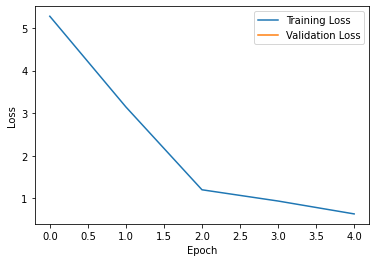

In [5]:
batch_size = 5
num_workers = 4
learning_rate = 0.0001 # 0.00005 - the best one so far
num_epochs = 5
num_classes = 5

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}")
print(f"Number of Classes: {num_classes}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

##change this
model = torch.load(os.path.join(os.getcwd(), 'pretrained/resnet18_model_77.pth')).to(device)

for iter in range(2):
    train_loader, test_loader = make_dataset_loaders(num_classes=num_classes, batch_size=batch_size, num_workers=num_workers)
    model, training_losses, val_losses = train(net=model, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, learning_rate=learning_rate)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.plot(test_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()